# Vizualizace fraktálů #

Import knihoven:

In [24]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
from numba import jit, prange

Definice fraktálových funkcí:

In [25]:
@jit(nopython=True)
def mandelbrot(c: complex, max_iter: int) -> int:
    """
    Vypočítá počet iterací, než sekvence Mandelbrotovy množiny opustí kruh o poloměru 2.

    Parametry:
    c (complex): Komplexní konstanta pro Mandelbrotovu množinu.
    max_iter (int): Maximální počet iterací.

    Návratová hodnota:
    int: Počet iterací, při kterých sekvence opustí kruh, nebo max_iter, pokud neunikne.
    """
    z = 0
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter

@jit(nopython=True)
def julia(z: complex, c: complex, max_iter: int) -> int:
    """
    Vypočítá počet iterací, než sekvence Juliovy množiny opustí kruh o poloměru 2.

    Parametry:
    z (complex): Počáteční komplexní hodnota.
    c (complex): Komplexní parametr pro Juliovu množinu.
    max_iter (int): Maximální počet iterací.

    Návratová hodnota:
    int: Počet iterací, při kterých sekvence opustí kruh, nebo max_iter, pokud neunikne.
    """
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter

Generování fraktálových dat:

In [26]:
@jit(nopython=True, parallel=True)
def generate_mandelbrot(xmin: float, xmax: float, ymin: float, ymax: float, width: int, height: int, max_iter: int) -> tuple:
    """
    Generuje data pro Mandelbrotův fraktál.

    Parametry:
    xmin (float): Minimální hodnota x.
    xmax (float): Maximální hodnota x.
    ymin (float): Minimální hodnota y.
    ymax (float): Maximální hodnota y.
    width (int): Šířka výstupního obrazu.
    height (int): Výška výstupního obrazu.
    max_iter (int): Maximální počet iterací.

    Návratová hodnota:
    tuple: Pole reprezentující rozsah x, rozsah y a fraktálová data.
    """
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width, height), dtype=np.int32)

    for i in prange(width):
        for j in range(height):
            n3[i, j] = mandelbrot(r1[i] + 1j * r2[j], max_iter)
    return r1, r2, n3

@jit(nopython=True, parallel=True)
def generate_julia(xmin: float, xmax: float, ymin: float, ymax: float, width: int, height: int, max_iter: int, c: complex) -> tuple:
    """
    Generuje data pro Juliův fraktál.

    Parametry:
    xmin (float): Minimální hodnota x.
    xmax (float): Maximální hodnota x.
    ymin (float): Minimální hodnota y.
    ymax (float): Maximální hodnota y.
    width (int): Šířka výstupního obrazu.
    height (int): Výška výstupního obrazu.
    max_iter (int): Maximální počet iterací.
    c (complex): Komplexní parametr pro Juliovu množinu.

    Návratová hodnota:
    tuple: Pole reprezentující rozsah x, rozsah y a fraktálová data.
    """
    r1 = np.linspace(xmin, xmax, width)
    r2 = np.linspace(ymin, ymax, height)
    n3 = np.empty((width, height), dtype=np.int32)

    for i in prange(width):
        for j in range(height):
            n3[i, j] = julia(r1[i] + 1j * r2[j], c, max_iter)
    return r1, r2, n3

Vykreslení fraktálu:

In [27]:
def plot_fractal(ax: plt.Axes, data: tuple, colormap: str = 'inferno') -> None:
    """
    Vykreslí fraktálová data na danou osu Matplotlibu.

    Parametry:
    ax (plt.Axes): Osa Matplotlibu, na kterou se bude vykreslovat.
    data (tuple): Data obsahující rozsah x, rozsah y a fraktálová data.
    colormap (str): Barevná mapa pro vizualizaci fraktálu.
    """
    r1, r2, n3 = data
    ax.imshow(n3.T, cmap=colormap, extent=(r1.min(), r1.max(), r2.min(), r2.max()))
    ax.set_aspect('auto')
    ax.figure.canvas.draw_idle()

Parametry:

In [28]:
xmin, xmax, ymin, ymax = -2.0, 2.0, -2.0, 2.0
width, height = 800, 800
max_iter = 256
c_julia = complex(-0.7, 0.27015)  # parametr pro Juliovu množinu

Interaktivní vizulace Mandelbrotovy množiny:

Aktualizováno: max_iter=256, zoom=1, colormap=inferno


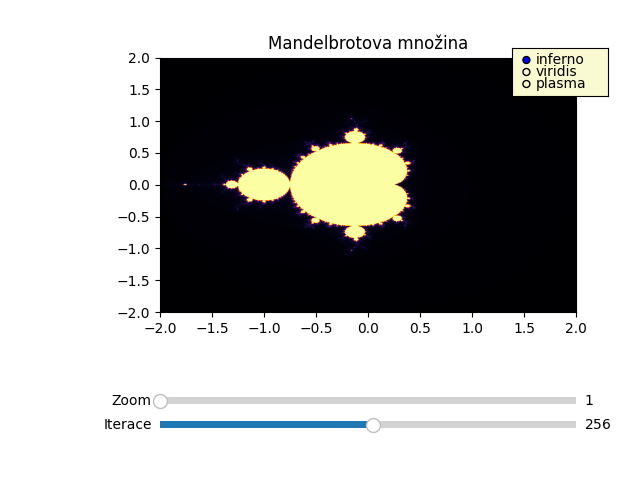

In [29]:
def interactive_mandelbrot() -> None:
    """
    Vytvoří interaktivní vizualizaci Mandelbrotova fraktálu s posuvníky pro iterace a zoom a možností výběru barevné mapy.
    """
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.35)
    axcolor = 'lightgoldenrodyellow'

    ax_iter = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
    ax_zoom = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
    ax_colormap = plt.axes([0.8, 0.8, 0.15, 0.1], facecolor=axcolor)

    s_iter = Slider(ax_iter, 'Iterace', 0, 500, valinit=max_iter, valstep=1)
    s_zoom = Slider(ax_zoom, 'Zoom', 1, 10, valinit=1, valstep=0.1)
    r_colormap = RadioButtons(ax_colormap, ('inferno', 'viridis', 'plasma'))

    def update(val):
        max_iter = int(s_iter.val)
        zoom = s_zoom.val
        colormap = r_colormap.value_selected
        
        xmin, xmax = -2.0 / zoom, 2.0 / zoom
        ymin, ymax = -2.0 / zoom, 2.0 / zoom
        
        fractal_data = generate_mandelbrot(xmin, xmax, ymin, ymax, width, height, max_iter)
        ax.clear()
        plot_fractal(ax, fractal_data, colormap)
        ax.set_title('Mandelbrotova množina')
        print(f"Aktualizováno: max_iter={max_iter}, zoom={zoom}, colormap={colormap}")

    s_iter.on_changed(update)
    s_zoom.on_changed(update)
    r_colormap.on_clicked(update)

    update(None)
    plt.show()

#SPUŠTĚNÍ
interactive_mandelbrot()

Interaktivní vizualizace Juliovy množiny:

Aktualizováno: max_iter=256, zoom=1, c_real=-0.7, c_imag=0.27015, colormap=inferno


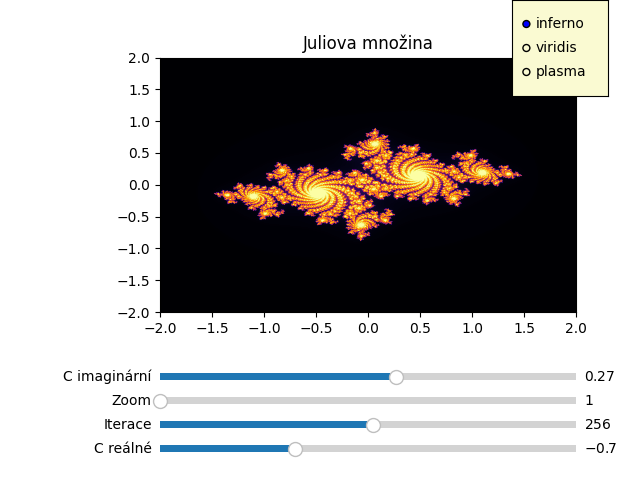

In [23]:
def interactive_julia() -> None:
    """
    Vytvoří interaktivní vizualizaci Juliovy množiny s posuvníky pro iterace, zoom a reálnou a imaginární část parametru, a možností výběru barevné mapy.
    """
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.35)
    axcolor = 'lightgoldenrodyellow'

    ax_iter = plt.axes([0.25, 0.10, 0.65, 0.03], facecolor=axcolor)
    ax_zoom = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
    ax_cx_real = plt.axes([0.25, 0.05, 0.65, 0.03], facecolor=axcolor)
    ax_cx_imag = plt.axes([0.25, 0.20, 0.65, 0.03], facecolor=axcolor)
    ax_colormap = plt.axes([0.8, 0.8, 0.15, 0.2], facecolor=axcolor)

    s_iter = Slider(ax_iter, 'Iterace', 0, 500, valinit=max_iter, valstep=1)
    s_zoom = Slider(ax_zoom, 'Zoom', 1, 10, valinit=1, valstep=0.1)
    s_cx_real = Slider(ax_cx_real, 'C reálné', -2.0, 2.0, valinit=c_julia.real)
    s_cx_imag = Slider(ax_cx_imag, 'C imaginární', -2.0, 2.0, valinit=c_julia.imag)
    r_colormap = RadioButtons(ax_colormap, ('inferno', 'viridis', 'plasma'))

    def update(val):
        max_iter = int(s_iter.val)
        zoom = s_zoom.val
        c_real = s_cx_real.val
        c_imag = s_cx_imag.val
        colormap = r_colormap.value_selected
        
        xmin, xmax = -2.0 / zoom, 2.0 / zoom
        ymin, ymax = -2.0 / zoom, 2.0 / zoom
        
        c = complex(c_real, c_imag)
        
        fractal_data = generate_julia(xmin, xmax, ymin, ymax, width, height, max_iter, c)
        ax.clear()
        plot_fractal(ax, fractal_data, colormap)
        ax.set_title('Juliova množina')
        print(f"Aktualizováno: max_iter={max_iter}, zoom={zoom}, c_real={c_real}, c_imag={c_imag}, colormap={colormap}")

    s_iter.on_changed(update)
    s_zoom.on_changed(update)
    s_cx_real.on_changed(update)
    s_cx_imag.on_changed(update)
    r_colormap.on_clicked(update)

    update(None)
    plt.show()

#SPUŠTĚNÍ
interactive_julia()